# Spike Gadgets Ephys and Video Syncing

In [1]:
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings
import os
import git
import bisect
import h5py

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal
from labellines import labelLine, labelLines


In [3]:
from spectral_connectivity import Multitaper, Connectivity

In [4]:
import numpy as np
import pandas as pd
import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [5]:
# setting path
sys.path.append('../../src')

In [6]:
import trodes.read_exported

In [7]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [8]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [9]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [10]:
import spikeinterface.full as si

In [11]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

In [12]:
%matplotlib inline

In [13]:
np.random.seed(seed=42)

# Part 0: Index of all the column names

raw directory
- raw_group0.dat
    - voltage_value: Array with voltage measurement for each channel at each timestamp
- timestamps.dat
    - voltage_time_stamp: The time stamp of each voltage measurement

parent directory
- 1.videoTimeStamps.cameraHWSync
    - frame_number: Calculated by getting the index of each video time stamp tuple 
    - PosTimestamp: The time stamp of each video frame
    - HWframeCount: Unknown value. Starts at 30742 and increases by 1 for each tuple  
    - HWTimestamp: Unknown value. All zeroes
    - video_time: Calculated by dividing the frame number by the fps(frames per second) 
    - video_seconds: video_time, but rounded to seconds  	
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_PosTimestamp 	
        - filledHWframeCount 	
        - filled_frame_number 	
        - filled_video_time 	
        - filled_video_seconds 	

DIO directory
- dio_ECU_Din1.dat
    - time: The time stamp the corresponds to the DIN input
    - state: Binary state of whether there is input from DIN or not 	
    - trial_number: Calculated by adding 1 to every time there is a DIN input
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_state 	
        - filled_trial_number

ss_output directory (Spike sorting with Spike interface)
- firings.npz
    - unit_id: All the units that had a spike train for the given timestamp 	
    - number_of_units: Calculated by counting the number of units that had a spike train

# Part 1: Inputting Data

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [14]:
protocol_name = "rc_extention"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [15]:
input_folder = "./data"

- Make this cell into non-code block if you are using the same file path for multiple runs

In [16]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [17]:
git_root

'/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls'

In [18]:
recording_filepath_glob = "data/test"

In [19]:
recording_filepath_glob = "data/good/*20221202*"

In [20]:
recording_absolute_path_glob = os.path.join(git_root, recording_filepath_glob)

In [21]:
# Getting all the file paths of the recording files(that happen to all end in `.rec`)
raw_data_all_files = glob.glob(recording_absolute_path_glob, recursive=True)

In [22]:
raw_data_all_files

['/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221202_134600_omission_and_competition_subject_6_1_and_6_2.rec']

## Extracting the data and the metadata from the Recording folder

- Creating a dictionary that has the directory as the key and a dictionary that has the file name as the key and the 

In [23]:

def find_closest(my_list, my_number):
    """
    Assumes my_list is sorted. Returns the closest value to my_number.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect.bisect_left(my_list, my_number)
    if pos == 0:
        return my_list[0]
    else:
        return my_list[pos - 1]

In [24]:
raw_data_file_path = raw_data_all_files[0]

In [25]:
raw_data_file_path

'/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221202_134600_omission_and_competition_subject_6_1_and_6_2.rec'

In [26]:
raw_data_dir_to_extracted_files = defaultdict(dict)
# Getting the basename of the recording
recording_dirname = os.path.basename(raw_data_file_path)
recording_basename = os.path.splitext(recording_dirname)[0]
# Extracting the files
file_to_data = trodes.read_exported.get_all_trodes_data_from_directory(raw_data_file_path)


/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_23_exporting_data/../../src/trodes/read_exported.py:70: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


file prefix: group0.coordinates.dat
directory prefix: raw
file prefix: timestamps.dat
directory prefix: raw
file prefix: raw_group0.dat
directory prefix: raw
file prefix: 1.videoTimeStamps.cameraHWSync
directory prefix: .
file prefix: 1.videoTimeStamps.cameraHWSync
directory prefix: .


/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_23_exporting_data/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221202_134600_omission_and_competition_subject_6_1_and_6_2.rec/20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged.timestampoffset/20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged.timestampoffset.txt
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_23_exporting_data/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221202_134600_omission_and_competition_subject_6_1_and_6_2.rec/20221202_134600_omission_and_competition_subject_6_1_and_6_

file prefix: analog_Headstage_GyroZ.dat
directory prefix: analog
file prefix: analog_ECU_Ain6.dat
directory prefix: analog
file prefix: analog_ECU_Aout1.dat
directory prefix: analog
file prefix: analog_Headstage_MagY.dat
directory prefix: analog
file prefix: analog_ECU_Ain8.dat
directory prefix: analog
file prefix: timestamps.dat
directory prefix: analog
file prefix: analog_Headstage_MagX.dat
directory prefix: analog
file prefix: analog_Headstage_AccelY.dat
directory prefix: analog
file prefix: analog_ECU_Ain3.dat
directory prefix: analog
file prefix: analog_Headstage_GyroX.dat
directory prefix: analog
file prefix: analog_ECU_Ain2.dat
directory prefix: analog
file prefix: analog_ECU_Aout4.dat
directory prefix: analog
file prefix: analog_Headstage_AccelX.dat
directory prefix: analog
file prefix: analog_ECU_Aout3.dat
directory prefix: analog
file prefix: analog_ECU_Ain1.dat
directory prefix: analog
file prefix: analog_ECU_Ain4.dat
directory prefix: analog
file prefix: analog_ECU_Ain7.dat

# Part 2: Looking over the data

## Looking over the ephys recording

- Getting the name of the ephys recording directory

In [27]:
file_to_data 

defaultdict(dict,
            {'20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged.raw': {'group0.coordinates.dat': {'description': 'Pad locations in microns',
               'byte_order': 'little endian',
               'original_file': '20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged.rec',
               'clockrate': '20000',
               'trodes_version': '2.3.2',
               'compile_date': 'Apr 12 2022',
               'compile_time': '15:21:02',
               'qt_version': '6.2.2',
               'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
               'controller_firmware': '3.17',
               'headstage_firmware': '2.2',
               'controller_serialnum': '00104 00176',
               'headstage_serialnum': '01601 00130',
               'autosettle': '0',
               'smartref': '0',
               'gyro': '0',
               'accelerometer': '0',
               'magnetometer': '1',
               'time_offse

In [28]:
raw_directory_dict = file_to_data["raw"]

- Getting the name of the files in the ephys recording directory

In [29]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'timestamps.dat', 'raw_group0.dat'])

In [30]:
raw_recording_fields_text = raw_directory_dict["raw_group0.dat"]

In [31]:
raw_recording_fields_text

{'description': 'Raw (unfiltered) data for one sorting group',
 'byte_order': 'little endian',
 'original_file': '20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged.rec',
 'clockrate': '20000',
 'trodes_version': '2.3.2',
 'compile_date': 'Apr 12 2022',
 'compile_time': '15:21:02',
 'qt_version': '6.2.2',
 'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
 'controller_firmware': '3.17',
 'headstage_firmware': '2.2',
 'controller_serialnum': '00104 00176',
 'headstage_serialnum': '01601 00130',
 'autosettle': '0',
 'smartref': '0',
 'gyro': '0',
 'accelerometer': '0',
 'magnetometer': '1',
 'time_offset': '0',
 'system_time_at_creation': '1670006785156',
 'timestamp_at_creation': '522374',
 'first_timestamp': '4919837',
 'sorting_group': '0',
 'num_channels': '32',
 'voltage_scaling': '0.195',
 'fields': '<voltage 32*int16>',
 'data': array([([-310, -138, -329, -435, -217, -393, -281, -253, -246, -190,  -56,  -35, -116,  284, 1023,  696,  417,  -92, -213, -258, -153

- Voltage Time Stamps

In [32]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'timestamps.dat', 'raw_group0.dat'])

In [33]:
voltage_timestamp_array = raw_directory_dict["timestamps.dat"]["data"]

In [34]:
voltage_timestamp_array[:5]

array([(4919837,), (4919838,), (4919839,), (4919840,), (4919841,)],
      dtype=[('time', '<u4')])

In [35]:
voltage_timestamp_array[-5:]

array([(71918310,), (71918311,), (71918312,), (71918313,), (71918314,)],
      dtype=[('time', '<u4')])

In [36]:
voltage_timestamp_array.shape

(66998478,)

- Converting the array to integers to be able to do calculations

    - u4 and i2 explanation: https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/

In [37]:
voltage_timestamp_array = voltage_timestamp_array.astype(int)

In [38]:
voltage_timestamp_array[:5]

array([4919837, 4919838, 4919839, 4919840, 4919841])

In [39]:
voltage_timestamp_array[-5:]

array([71918310, 71918311, 71918312, 71918313, 71918314])

In [40]:
voltage_timestamp_array.shape

(66998478,)

# Exporting Video

## Looking over the video files

In [41]:
parent_directory_dict = file_to_data["."]

In [42]:
video_time_stamp_dict = parent_directory_dict["1.videoTimeStamps.cameraHWSync"]

In [43]:
video_time_stamp_dict

{'clock rate': '30000',
 'fields': '<PosTimestamp uint32><HWframeCount uint32><HWTimestamp uint64>',
 'data': array([( 4919835, 0, 0), ( 4921221, 0, 0), ( 4921221, 0, 0), ...,
        (71916928, 0, 0), (71918314, 0, 0), (71918314, 0, 0)],
       dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')]),
 'absolute_file_path': '/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221202_134600_omission_and_competition_subject_6_1_and_6_2.rec/20221202_134600_omission_and_competition_subject_6_1_and_6_2.1.videoTimeStamps.cameraHWSync'}

In [44]:
video_time_stamp_dict["data"]

array([( 4919835, 0, 0), ( 4921221, 0, 0), ( 4921221, 0, 0), ...,
       (71916928, 0, 0), (71918314, 0, 0), (71918314, 0, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [45]:
video_time_stamp_dict["data"][:5]

array([(4919835, 0, 0), (4921221, 0, 0), (4921221, 0, 0), (4922607, 0, 0),
       (4922607, 0, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [46]:
video_time_stamp_dict["data"][-5:]

array([(71915542, 0, 0), (71915542, 0, 0), (71916928, 0, 0),
       (71918314, 0, 0), (71918314, 0, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [47]:
video_time_stamp_dict["data"].shape

(83387,)

In [48]:
video_time_stamp_array = video_time_stamp_dict["data"]["PosTimestamp"].astype(int) - voltage_timestamp_array[0] + 1

In [49]:
video_time_stamp_array[video_time_stamp_array <= 0] = 0

In [50]:
video_time_stamp_array

array([       0,     1385,     1385, ..., 66997092, 66998478, 66998478])

In [258]:
video_df = pd.DataFrame(video_time_stamp_array, columns=["timestamp"]).reset_index()
video_df.rename(columns={"index": "video_frame"})

,video_frame,timestamp
0,0,0
1,1,1385
2,2,1385
3,3,2771
4,4,2771
...,...,...
83382,83382,66995706
83383,83383,66995706
83384,83384,66997092
83385,83385,66998478


# Exporting SLEAP

# Getting the coordinates of each mouse to the reward port

In [259]:
filename_1_subj = "./proc/sleap/20221202_134600_omission_and_competition_subject_6_1_and_6_2.1.fixed.1_subj.round_5.analysis.h5"
filename_2_subj = "./proc/sleap/20221202_134600_omission_and_competition_subject_6_1_and_6_2.1.fixed.2_subj.round_5.analysis.h5"

## Loading the data

We use the [h5py](https://www.h5py.org) package to load data from the HDF5. This is already installed in Colab. If your running analysis code on your local machine and have SLEAP installed, then `h5py` and other packages we use are already installed in your SLEAP conda environment. Otherwise, you may need to use `conda` or `pip` to install `h5py` as well as `numpy`, `scipy`, `matplotlib`, `seaborn`, and any other packages you want use in your analysis code.

Let's load the file and take a peek.

- 1 Subject Posetracking

In [327]:
with h5py.File(filename_1_subj, "r") as f:
    dset_names = list(f.keys())
    single_subject_locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]
    track_names = f["track_names"][:].T
    track_names = [str(name.decode('UTF-8')) for name in track_names]

print("===filename===")
print(filename_2_subj)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(single_subject_locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()


===filename===
./proc/sleap/20221202_134600_omission_and_competition_subject_6_1_and_6_2.1.fixed.2_subj.round_5.analysis.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(83387, 6, 2, 1)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [328]:
track_names

['6_1']

- 2 Subject Posetracking

In [329]:
with h5py.File(filename_2_subj, "r") as f:
    dset_names = list(f.keys())
    both_subject_locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]
    track_names = f["track_names"][:].T
    track_names = [str(name.decode('UTF-8')) for name in track_names]

print("===filename===")
print(filename_2_subj)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(both_subject_locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()


===filename===
./proc/sleap/20221202_134600_omission_and_competition_subject_6_1_and_6_2.1.fixed.2_subj.round_5.analysis.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(83387, 6, 2, 113)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [330]:
track_names

['6_1',
 '6_2',
 'track_273',
 'track_274',
 'track_275',
 'track_276',
 'track_278',
 'track_279',
 'track_280',
 'track_281',
 'track_282',
 'track_288',
 'track_289',
 'track_290',
 'track_291',
 'track_292',
 'track_300',
 'track_301',
 'track_302',
 'track_303',
 'track_304',
 'track_305',
 'track_306',
 'track_307',
 'track_310',
 'track_311',
 'track_314',
 'track_315',
 'track_317',
 'track_318',
 'track_319',
 'track_320',
 'track_323',
 'track_324',
 'track_325',
 'track_326',
 'track_327',
 'track_328',
 'track_329',
 'track_330',
 'track_331',
 'track_332',
 'track_334',
 'track_335',
 'track_338',
 'track_339',
 'track_346',
 'track_347',
 'track_351',
 'track_352',
 'track_355',
 'track_356',
 'track_357',
 'track_358',
 'track_359',
 'track_360',
 'track_361',
 'track_362',
 'track_365',
 'track_366',
 'track_367',
 'track_368',
 'track_370',
 'track_371',
 'track_373',
 'track_374',
 'track_376',
 'track_377',
 'track_378',
 'track_379',
 'track_381',
 'track_382',
 'tr

- Filtering the pose estimations with both subjects

In [331]:
locations = both_subject_locations[:,:,:,:2]

- Removing all frames where trials are not being recorded

In [332]:
locations.shape

(83387, 6, 2, 2)

In [333]:
locations[:237,:,:,:] = np.nan

In [334]:
locations[31649:36956,:,:,:] = np.nan

In [335]:
locations[83325:,:,:,:] = np.nan

- Removing all pose estimations with subject 2

In [336]:
locations[:36956,:,:,1] = np.nan

- Removing all pose estimations with subject 1, and replacing with pose tracking when the subject was alone

In [337]:
locations[:36956,:,:,0] = np.nan

In [338]:
single_subject_locations[237:31649].shape

(31412, 6, 2, 1)

In [339]:
locations[237:31649,:,:,0] = single_subject_locations[237:31649,:,:,0]

In [340]:
locations.shape

(83387, 6, 2, 2)

In our example file, the shape of the locations matrix (the `tracks` dataset) is (3000, 13, 2, 2) **after it is transposed** (with the `.T`). We transpose the data when loading it in Python; no transpose is needed when using MATLAB. This is because Python and MATLAB expect matrices to be stored differently.

Here's what each dimension of the matrix means:

- 3000: the number of frames;

- 13: the number of nodes in the skeleton (we've also loaded and displayed the `node_names` dataset with the names of these 13 nodes);

- 2: for the x and y coordinates;

- 2: the number of distinct animal identities which were found (we have 2 flies in the video clip and they were tracked perfectly, so we ended up with exactly 2 track, but there may be more tracks than animals if tracking didn't work as well).

We can get these counts from the shape of the matrix, like so:


In [341]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 83387
node count: 6
instance count: 2


Now that we've loaded the data, let's see some different things we can do with it...

## Fill missing values

In [311]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [323]:
locations = fill_missing(locations)

In [324]:
locations.shape

(83387, 6, 2, 2)

In [342]:
for track_index, track in enumerate(track_names[:2]):
    for node_index, node in enumerate(node_names):
        print("{} {}".format(track, node))
        print(locations[:,node_index,:,track_index].shape)
        video_df["{}_{}_x".format(track, node)] = locations[:,node_index,0,track_index]
        video_df["{}_{}_y".format(track, node)] = locations[:,node_index,1,track_index]


6_1 left_ear
(83387, 2)
6_1 right_ear
(83387, 2)
6_1 nose
(83387, 2)
6_1 tail_base
(83387, 2)
6_1 thorax
(83387, 2)
6_1 forehead
(83387, 2)
6_2 left_ear
(83387, 2)
6_2 right_ear
(83387, 2)
6_2 nose
(83387, 2)
6_2 tail_base
(83387, 2)
6_2 thorax
(83387, 2)
6_2 forehead
(83387, 2)


In [346]:
video_df[250:83325]

,index,timestamp,6_1_left_ear_x,6_1_left_ear_y,6_1_right_ear_x,6_1_right_ear_y,6_1_nose_x,6_1_nose_y,6_1_tail_base_x,6_1_tail_base_y,...,6_2_right_ear_x,6_2_right_ear_y,6_2_nose_x,6_2_nose_y,6_2_tail_base_x,6_2_tail_base_y,6_2_thorax_x,6_2_thorax_y,6_2_forehead_x,6_2_forehead_y
250,250,200951,995.950195,883.735779,931.896545,868.193359,967.450073,927.593445,1051.915894,760.460876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,251,200951,996.477600,876.352661,932.217773,864.088440,967.425293,924.182800,1052.040527,760.416260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,252,202336,999.741211,876.062805,932.534058,863.935364,967.970398,924.217163,1051.917969,760.446533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,253,203722,999.741272,876.544983,932.626587,864.473083,968.055969,928.170959,1051.795898,760.032471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,254,203722,1000.041016,875.717346,935.577332,863.890991,967.943481,924.205994,1051.817627,760.243103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83320,83320,66945815,976.120117,872.134216,936.426392,867.798462,951.961182,924.207886,1044.364502,751.319397,...,691.662964,511.349640,NaN,NaN,751.995361,387.643280,719.685669,436.445099,712.166382,528.467896
83321,83321,66945815,976.038147,872.143982,936.401367,867.786743,951.968201,924.202820,1044.353027,751.329285,...,691.659546,511.420776,NaN,NaN,751.996155,387.640930,719.712036,436.442352,712.315491,528.452454
83322,83322,66947201,975.959900,872.187317,936.333801,867.823975,951.983093,924.230164,1044.353394,751.337769,...,691.589355,511.420685,NaN,NaN,751.990967,387.644165,719.696472,436.450653,715.920715,531.749329
83323,83323,66947401,975.857666,872.355591,932.047668,867.787231,951.637390,927.867249,1044.348389,751.309387,...,691.775024,508.453827,NaN,NaN,751.984802,387.616364,719.698303,436.406494,712.258423,528.416748


In [348]:
video_df.to_csv("./proc/sleap_posetracking_20221202_subj_6_1_vs_6_2.csv")

# Exporting LFP

### Brain Region to Channel

```
- All Trodes
    - 21, 31, 15, 14, 13
- mPFC:
    - 21 (0 to 31 on Spike interface)
    - 22(1 to 32 on Trodes)
- MD
    - 1 (EIB)
        - Maybe actually 16
    - 31(0 to 31 Spike interface)
        - Maybe actually 16
    - 32(1 to 32 Trodes)
- vHPC
    - 17(EIB)
    - 15(0 to 31 on Spike interface)
    - 16(1 to 32 Trodes)
- BLA
    - 18(BLA)
    - 14(0 to 31 Spike interface)
    - 15(1 to 32 Trodes)
- LH 18
    - 19(EIB)
    - 13(0 to 31 Spike interface)
    - 14(1 to 32 Trodes)
```

## Loading in the Preprocessed LFP 

In [67]:
lfp_preprocessing_filepath_glob = glob.glob("../2023_05_17_lfp_analysis/proc/20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged/lfp_preprocessing")

In [68]:
lfp_preprocessing_filepath_glob

['../2023_05_17_lfp_analysis/proc/20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged/lfp_preprocessing']

```
MD EIB: 0(1 on Nancy notebook) Spike Gadgets/Spike Interface: 0
vHPC EIB: 16(17 on Nancy notebook) Spike Gadgets/Spike Interface: 31
BLA EIB: 17(18 on Nancy notebook) Spike Gadgets/Spike Interface: 30
LH EIB: 18(19 on Nancy notebook) Spike Gadgets/Spike Interface: 29
```

In [70]:
time_range=(1000, 1005)
resampled_frequency = 1000

In [71]:
time_halfbandwidth_product=10

In [72]:
resampled_frequency = 1000

../2023_05_17_lfp_analysis/proc/20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged/lfp_preprocessing


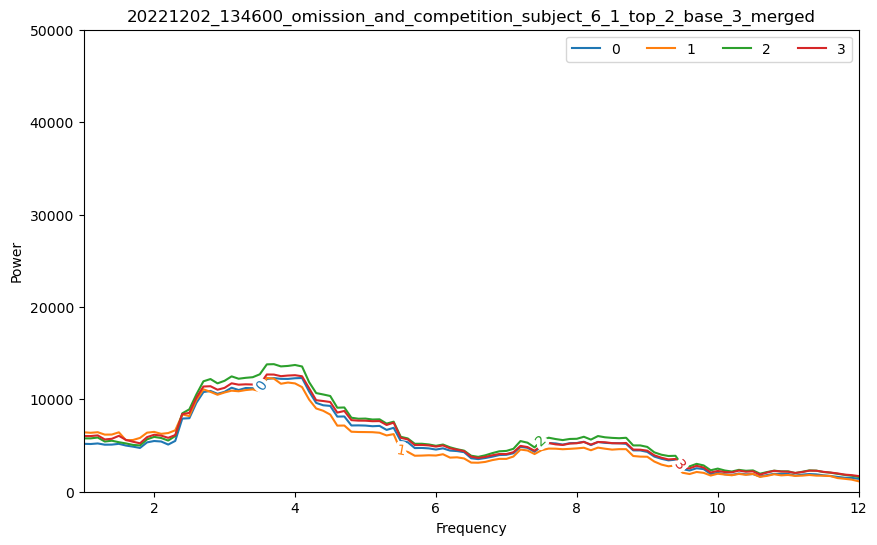

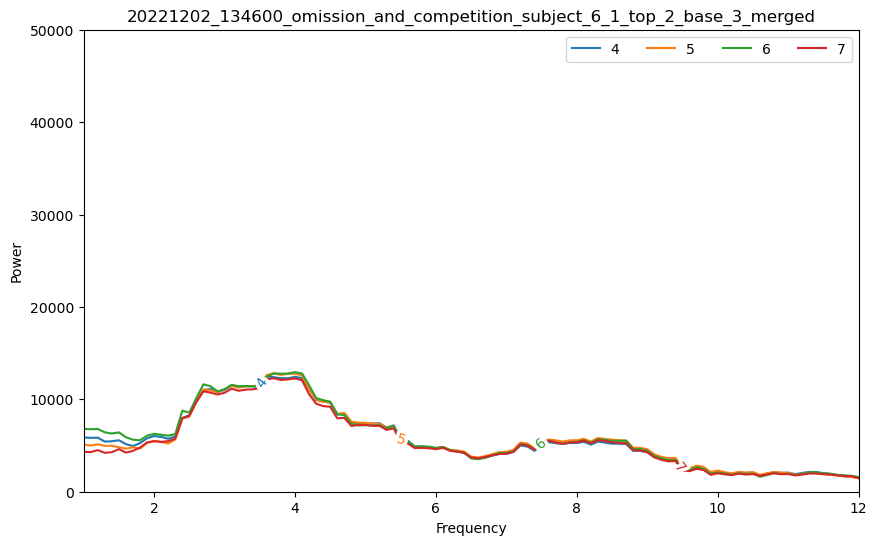

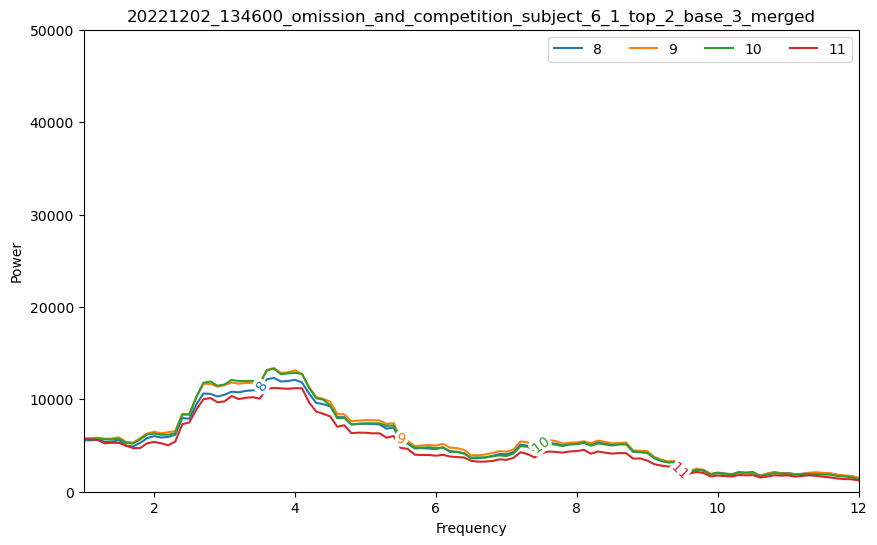

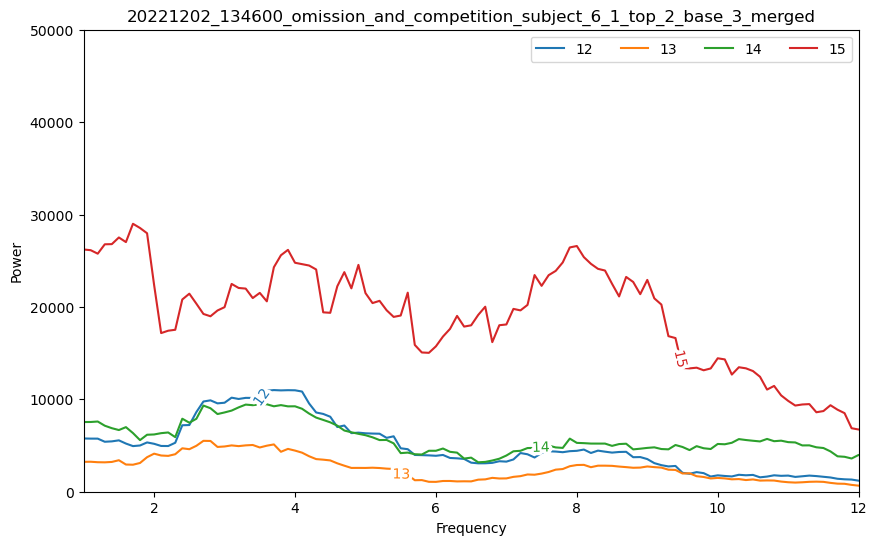

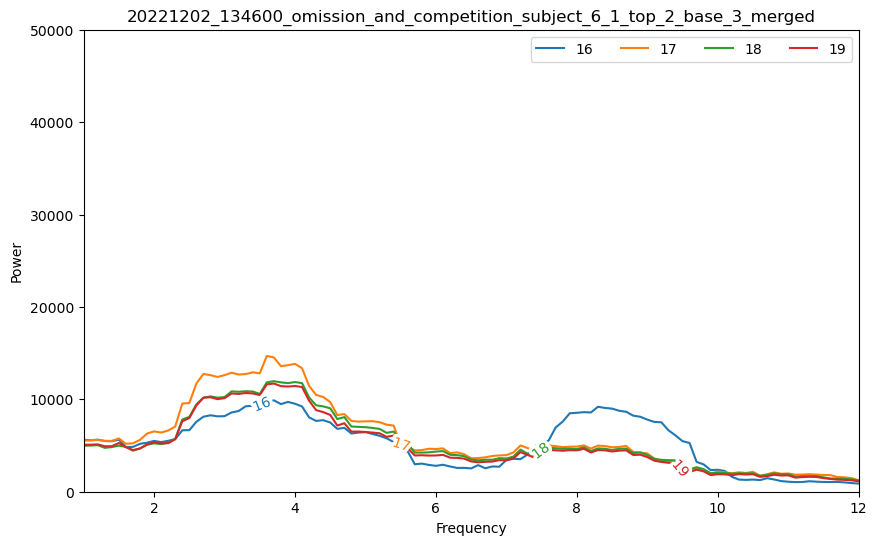

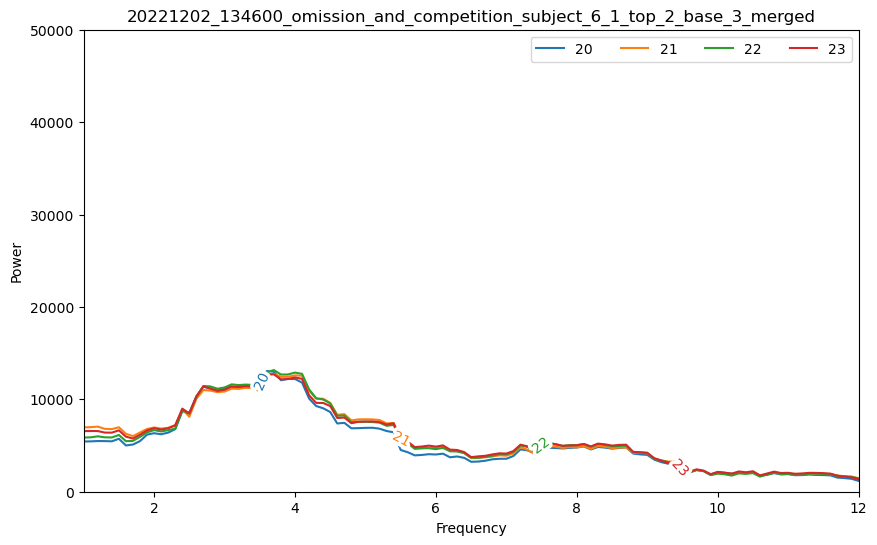

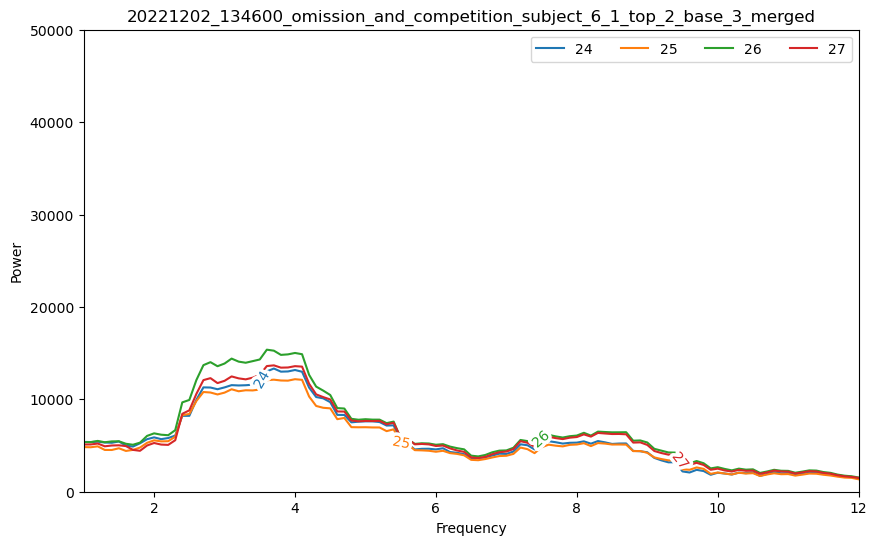

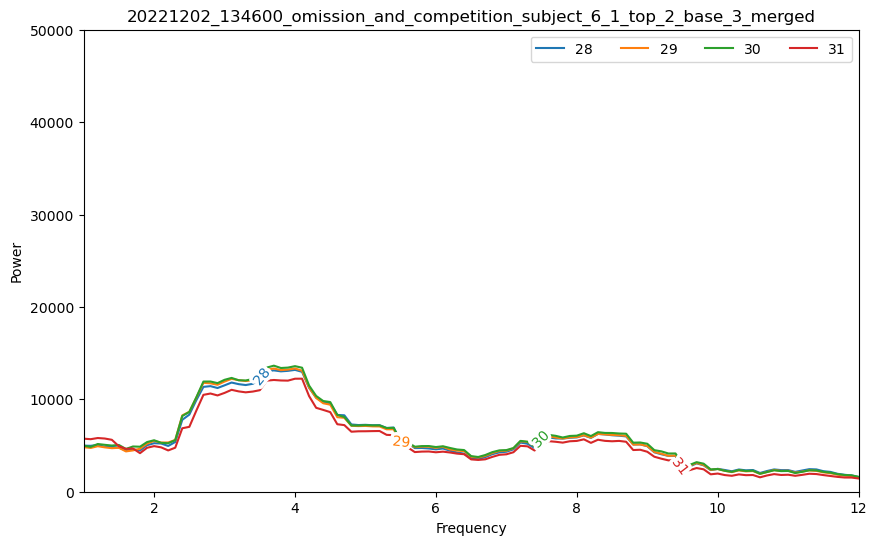

In [73]:
for preprocessed_lfp_path in lfp_preprocessing_filepath_glob:
    print(preprocessed_lfp_path)
    recording_intermediate = spikeinterface.core.load_extractor(file_or_folder_or_dict=preprocessed_lfp_path)
    recording_basename = os.path.basename(os.path.dirname(preprocessed_lfp_path))
    parent_output_directory = os.path.dirname(preprocessed_lfp_path)

    
    # Resampling
    recording_intermediate = spikeinterface.preprocessing.resample(recording_intermediate, resample_rate=resampled_frequency) 
#     sw.plot_timeseries(recording_intermediate, time_range=time_range, channel_ids=channel_ids, show_channel_ids=True)

    # Getting the traces
    
    traces = recording_intermediate.get_traces(start_frame=100*1000, end_frame=110*1000)
    
    # Compute multitaper spectral estimate
    m = Multitaper(time_halfbandwidth_product=time_halfbandwidth_product, time_series=traces,
                   sampling_frequency=resampled_frequency)
    
    # Sets up computing connectivity measures/power from multitaper spectral estimate
    c = Connectivity.from_multitaper(m)
    
    for num in range(8):
        channels = [int(num) for num in recording_intermediate.channel_ids[num*4: num*4+4]]
        
    
    
        fig, ax = plt.subplots()
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Power")
        ax.plot(c.frequencies, c.power().squeeze()[:,channels], label=channels)
        ax.set_xlim(1,12)
        ax.set_ylim(0, 50000)



        ax.legend(ncol=4)
        labelLines(ax.get_lines(), zorder=2.5)
        plt.title(recording_basename)
        plt.show()


In [74]:
brain_region_to_channel = {"LH": "13", "BLA": "14", "vHPC": "15", "MD": "16", "mPFC": "21"}

In [92]:
brain_region_to_channel = {k: int(v) for k, v in sorted(brain_region_to_channel.items(), key=lambda item: item[1])}

In [139]:
np_issue_files = []
for preprocessed_lfp_path in lfp_preprocessing_filepath_glob:
    try:
        print(preprocessed_lfp_path)
        recording_intermediate = spikeinterface.core.load_extractor(file_or_folder_or_dict=preprocessed_lfp_path)
        recording_basename = os.path.basename(os.path.dirname(preprocessed_lfp_path))
        parent_output_directory = os.path.dirname(preprocessed_lfp_path)

        # Resampling
        recording_resampled = spikeinterface.preprocessing.resample(recording_intermediate, resample_rate=resampled_frequency) 

        # Getting the traces for all channels
        traces = recording_resampled.get_traces(start_frame=0, end_frame=recording_resampled.get_num_samples()-1)
        
        # Getting the traces for channels of interest
        traces = traces[:,list(brain_region_to_channel.values())]
        
        # Getting the 
        # Create a new row where each element is its index
        timestamp_column = (np.arange(traces.shape[0]) * (recording_intermediate.get_sampling_frequency() / resampled_frequency)).astype(int)

        # Add the new row to the array
        traces = np.column_stack((timestamp_column, traces)).astype(int)
        
        # Saving the trace to a Numpy file
        traces_filename = "{}.traces.npy".format(recording_basename)
        np.save(file=os.path.join("./proc/lfp", traces_filename), arr=traces)
    except:
        np_issue_files.append(preprocessed_lfp_path)

../2023_05_17_lfp_analysis/proc/20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged/lfp_preprocessing


In [242]:
brain_region_to_channel.values()

dict_values([13, 14, 15, 16, 21])

In [241]:
list(brain_region_to_channel.keys())

['LH', 'BLA', 'vHPC', 'MD', 'mPFC']

In [245]:
traces_df = pd.DataFrame(traces, columns=["timestamp"] + list(brain_region_to_channel.keys()))

In [254]:
traces_df["subject"] = "6.1"

In [255]:
traces_df.head()

,timestamp,LH,BLA,vHPC,MD,mPFC,subject
0,0,-10,366,-135,14,-111,6.1
1,20,-81,357,-81,-109,-263,6.1
2,40,-78,345,94,-153,-162,6.1
3,60,-120,254,142,-163,-27,6.1
4,80,-167,129,0,-144,-98,6.1


In [256]:
traces_df.tail()

,timestamp,LH,BLA,vHPC,MD,mPFC,subject
3349543,66990860,-123,-148,402,-174,268,6.1
3349544,66990880,-104,-203,365,-64,150,6.1
3349545,66990900,-113,-301,382,-54,82,6.1
3349546,66990920,-106,-305,347,-124,101,6.1
3349547,66990940,-67,-213,256,-137,114,6.1


In [257]:
traces_df.to_csv("./proc/lfp_20221202_subj_6_1_vs_6_2.csv")

In [272]:
pd.read_csv("./proc/lfp_20221202_subj_6_1_vs_6_2.csv")

,Unnamed: 0,timestamp,LH,BLA,vHPC,MD,mPFC,subject
0,0,0,-10,366,-135,14,-111,6.1
1,1,20,-81,357,-81,-109,-263,6.1
2,2,40,-78,345,94,-153,-162,6.1
3,3,60,-120,254,142,-163,-27,6.1
4,4,80,-167,129,0,-144,-98,6.1
...,...,...,...,...,...,...,...,...
3349543,3349543,66990860,-123,-148,402,-174,268,6.1
3349544,3349544,66990880,-104,-203,365,-64,150,6.1
3349545,3349545,66990900,-113,-301,382,-54,82,6.1
3349546,3349546,66990920,-106,-305,347,-124,101,6.1


In [140]:
timestamp_column.shape

(3349548,)

In [141]:
traces[:,0][-1]

66990940

In [142]:
recording_intermediate.get_num_samples()

66990971

In [143]:
traces[0,0]

0

In [144]:
video_df.to_numpy().shape

(83387, 26)

# Exporting Spike Sorting

In [145]:
spike_clusters = np.load("../2023_05_17_spike_analysis/proc/20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged/phy/spike_clusters.npy")

In [146]:
spike_clusters

array([54, 59,  5, ..., 69, 44, 51], dtype=int32)

- The classification of each unit

In [148]:
cluster_group_df = pd.read_csv("../2023_05_17_spike_analysis/proc/20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged/phy/cluster_info.tsv", sep="\t")

In [149]:
cluster_group_df

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,0,909.5,0,0,0.0,2.822470,good,9454,0,1
1,1,471.0,0,0,0.0,6.946309,good,23267,0,2
2,2,356.0,0,0,0.0,0.564852,mua,1892,0,3
3,3,212.0,1,0,20.0,1.820544,mua,6098,0,4
4,4,197.0,1,0,20.0,1.764417,mua,5910,0,5
...,...,...,...,...,...,...,...,...,...,...
66,67,1240.0,30,0,600.0,0.631130,mua,2114,0,68
67,68,292.0,30,0,600.0,0.563658,mua,1888,0,69
68,69,639.0,31,0,620.0,19.451577,good,65154,0,70
69,70,444.0,4,0,80.0,8.473082,mua,28381,0,12


- Filtering for the good units

In [168]:
brain_region_to_channel

{'LH': 13, 'BLA': 14, 'vHPC': 15, 'MD': 16, 'mPFC': 21}

In [169]:
good_unit_cluster_info_df = cluster_group_df[cluster_group_df["group"] == "good"]

In [170]:
good_unit_cluster_info_df

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,0,909.5,0,0,0.0,2.822470,good,9454,0,1
1,1,471.0,0,0,0.0,6.946309,good,23267,0,2
5,5,776.0,2,0,40.0,19.746542,good,66142,0,6
8,8,529.0,3,0,60.0,3.148185,good,10545,0,9
11,12,606.0,5,0,100.0,8.333362,good,27913,0,13
12,13,503.0,5,0,100.0,6.049771,good,20264,0,14
13,14,912.0,5,0,100.0,8.908962,good,29841,0,15
14,15,1078.0,6,0,120.0,5.854520,good,19610,0,16
15,16,639.0,7,0,140.0,18.872693,good,63215,0,17
16,17,300.0,8,0,160.0,7.758359,good,25987,0,18


In [171]:
good_unit_unique_ids = good_unit_cluster_info_df["cluster_id"].values

In [172]:
good_unit_unique_ids

array([ 0,  1,  5,  8, 12, 13, 14, 15, 16, 17, 20, 28, 39, 40, 41, 42, 43,
       44, 45, 51, 52, 55, 56, 59, 60, 62, 63, 64, 69])

- The times that all the spikes happened

In [173]:
spike_times = np.load("../2023_05_17_spike_analysis/proc/20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged/phy/spike_times.npy")

In [174]:
spike_times[:10]

array([[  5],
       [147],
       [236],
       [291],
       [325],
       [362],
       [406],
       [461],
       [527],
       [610]])

- Getting a list of the IDs that were good from the list of unit ids for all the firings

In [175]:
good_unit_mask = np.isin(spike_clusters, good_unit_unique_ids)

In [176]:
good_unit_all_ids = spike_clusters[good_unit_mask]

In [177]:
good_unit_all_ids.shape

(843091,)

In [178]:
good_unit_all_ids[:10]

array([59,  5, 60, 56, 39, 51, 44, 45, 59,  0], dtype=int32)

- Getting the time that the good units fired

In [179]:
good_unit_times = spike_times[good_unit_mask].T[0]

In [180]:
good_unit_times.shape

(843091,)

In [222]:
good_unit_timestamp_df = pd.DataFrame({
    'timestamp': good_unit_times,
    'cluster_id': good_unit_all_ids
})

In [223]:
good_unit_timestamp_df.head()

,timestamp,cluster_id
0,147,59
1,236,5
2,291,60
3,325,56
4,362,39


In [224]:
good_unit_cluster_info_df.head()

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,0,909.5,0,0,0.0,2.822470,good,9454,0,1
1,1,471.0,0,0,0.0,6.946309,good,23267,0,2
5,5,776.0,2,0,40.0,19.746542,good,66142,0,6
8,8,529.0,3,0,60.0,3.148185,good,10545,0,9
11,12,606.0,5,0,100.0,8.333362,good,27913,0,13


In [225]:
good_unit_merged_df = pd.merge(good_unit_timestamp_df, good_unit_cluster_info_df, left_on="cluster_id", right_on="cluster_id")
good_unit_merged_df = good_unit_merged_df.sort_values("timestamp").reset_index(drop=True)

In [235]:
good_unit_merged_df.head()

,timestamp,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,brain_region
0,147,59,483.0,27,0,540.0,14.821699,good,49646,0,60,mPFC
1,236,5,776.0,2,0,40.0,19.746542,good,66142,0,6,mPFC
2,291,60,573.5,28,0,560.0,16.525809,good,55354,0,61,mPFC
3,325,56,916.5,26,0,520.0,5.564033,good,18637,0,57,mPFC
4,362,39,471.5,21,0,420.0,2.378231,good,7966,0,40,mPFC


In [229]:
channel_to_brain_region = {v: k for k,v in brain_region_to_channel.items()}

In [230]:
channel_to_brain_region

{13: 'LH', 14: 'BLA', 15: 'vHPC', 16: 'MD', 21: 'mPFC'}

In [231]:
good_unit_merged_df["brain_region"] = good_unit_merged_df['ch'].map(lambda x: channel_to_brain_region.get(x, 'mPFC'))


In [250]:
good_unit_merged_df["subject"] = "6.1"

In [251]:
good_unit_merged_df

,timestamp,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,brain_region,subject
0,147,59,483.0,27,0,540.0,14.821699,good,49646,0,60,mPFC,6.1
1,236,5,776.0,2,0,40.0,19.746542,good,66142,0,6,mPFC,6.1
2,291,60,573.5,28,0,560.0,16.525809,good,55354,0,61,mPFC,6.1
3,325,56,916.5,26,0,520.0,5.564033,good,18637,0,57,mPFC,6.1
4,362,39,471.5,21,0,420.0,2.378231,good,7966,0,40,mPFC,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
843086,66990353,28,649.5,16,0,320.0,7.742834,good,25935,0,29,MD,6.1
843087,66990556,16,639.0,7,0,140.0,18.872693,good,63215,0,17,mPFC,6.1
843088,66990714,69,639.0,31,0,620.0,19.451577,good,65154,0,70,mPFC,6.1
843089,66990814,44,455.0,22,0,440.0,12.581098,good,42141,0,45,mPFC,6.1


In [252]:
good_unit_merged_df.to_csv("./proc/spike_times_20221202_subj_6_1_vs_6_2.csv")

In [271]:
pd.read_csv("./proc/spike_times_20221202_subj_6_1_vs_6_2.csv")

,Unnamed: 0,timestamp,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,brain_region,subject
0,0,147,59,483.0,27,0,540.0,14.821699,good,49646,0,60,mPFC,6.1
1,1,236,5,776.0,2,0,40.0,19.746542,good,66142,0,6,mPFC,6.1
2,2,291,60,573.5,28,0,560.0,16.525809,good,55354,0,61,mPFC,6.1
3,3,325,56,916.5,26,0,520.0,5.564033,good,18637,0,57,mPFC,6.1
4,4,362,39,471.5,21,0,420.0,2.378231,good,7966,0,40,mPFC,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843086,843086,66990353,28,649.5,16,0,320.0,7.742834,good,25935,0,29,MD,6.1
843087,843087,66990556,16,639.0,7,0,140.0,18.872693,good,63215,0,17,mPFC,6.1
843088,843088,66990714,69,639.0,31,0,620.0,19.451577,good,65154,0,70,mPFC,6.1
843089,843089,66990814,44,455.0,22,0,440.0,12.581098,good,42141,0,45,mPFC,6.1


# Exporting MED-PC

## Looking over the MED-PC Data

- Box 1 Port Entries
    - ECU Din3
- Box 2 Port Entries
    - Controller Din1
- Box 1 Tone playing
    - ECU Din1

In [350]:
DIO_directory_name = trodes.read_exported.get_key_with_substring(file_to_data, substring="DIO")

In [351]:
DIO_directory_name

'DIO'

In [352]:
DIO_directory_dict = file_to_data[DIO_directory_name]

In [353]:
DIO_directory_dict.keys()

dict_keys(['dio_ECU_Dout10.dat', 'dio_ECU_Dout23.dat', 'dio_ECU_Dout6.dat', 'dio_Controller_Din3.dat', 'dio_ECU_Din7.dat', 'dio_ECU_Dout2.dat', 'dio_ECU_Dout18.dat', 'dio_ECU_Din18.dat', 'dio_ECU_Din19.dat', 'dio_ECU_Din16.dat', 'dio_ECU_Dout30.dat', 'dio_ECU_Din10.dat', 'dio_ECU_Dout7.dat', 'dio_ECU_Din30.dat', 'dio_ECU_Din9.dat', 'dio_ECU_Din32.dat', 'dio_ECU_Din29.dat', 'dio_ECU_Dout20.dat', 'dio_ECU_Din17.dat', 'dio_ECU_Din2.dat', 'dio_ECU_Din15.dat', 'dio_ECU_Dout28.dat', 'dio_ECU_Din12.dat', 'dio_ECU_Dout22.dat', 'dio_ECU_Din31.dat', 'dio_ECU_Din23.dat', 'dio_ECU_Dout1.dat', 'dio_ECU_Din5.dat', 'dio_ECU_Dout32.dat', 'dio_ECU_Dout21.dat', 'dio_ECU_Dout19.dat', 'dio_ECU_Din4.dat', 'dio_ECU_Dout13.dat', 'dio_ECU_Dout5.dat', 'dio_ECU_Dout14.dat', 'dio_ECU_Dout31.dat', 'dio_ECU_Din20.dat', 'dio_ECU_Dout3.dat', 'dio_ECU_Din25.dat', 'dio_ECU_Dout25.dat', 'dio_ECU_Din24.dat', 'dio_ECU_Dout9.dat', 'dio_ECU_Din28.dat', 'dio_ECU_Din6.dat', 'dio_ECU_Din26.dat', 'dio_ECU_Din21.dat', 'dio_ECU_

### Tone Onset Signal

In [354]:
tone_onset_DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din1.dat", return_first=True)

In [355]:
tone_onset_DIN_file_name

'dio_ECU_Din1.dat'

In [356]:
tone_onset_DIN_state_array = DIO_directory_dict[tone_onset_DIN_file_name]["data"]

In [357]:
tone_onset_DIN_state_array

array([( 4919837, 1), ( 5110265, 0), ( 6310663, 1), ( 6510663, 0),
       ( 7910662, 1), ( 8110661, 0), ( 9710660, 1), ( 9910657, 0),
       (11310658, 1), (11510659, 0), (12810657, 1), (13010657, 0),
       (14810655, 1), (15010655, 0), (16710653, 1), (16910653, 0),
       (18510652, 1), (18710651, 0), (20110658, 1), (20310650, 0),
       (21910649, 1), (22110648, 0), (23910646, 1), (24110646, 0),
       (25710642, 1), (25910642, 0), (28110642, 1), (28310642, 0),
       (29910641, 1), (30110640, 0), (30310238, 1), (34668633, 0),
       (35869034, 1), (36069035, 0), (37469033, 1), (37669030, 0),
       (39269032, 1), (39469031, 0), (40869030, 1), (41069030, 0),
       (42369029, 1), (42569028, 0), (44369024, 1), (44569026, 0),
       (46269025, 1), (46469022, 0), (48069023, 1), (48269023, 0),
       (49669022, 1), (49869019, 0), (51469020, 1), (51669022, 0),
       (53469018, 1), (53669018, 0), (55269017, 1), (55469014, 0),
       (57669012, 1), (57869014, 0), (59469010, 1), (59669013,

(array([35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

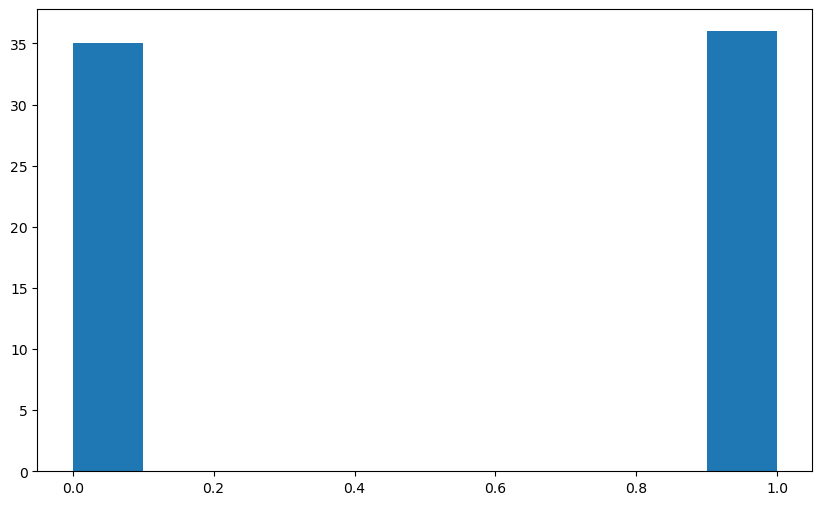

In [358]:
plt.hist([tup[1] for tup in tone_onset_DIN_state_array])

Text(0.5, 1.0, 'Din State Change against Timestamps')

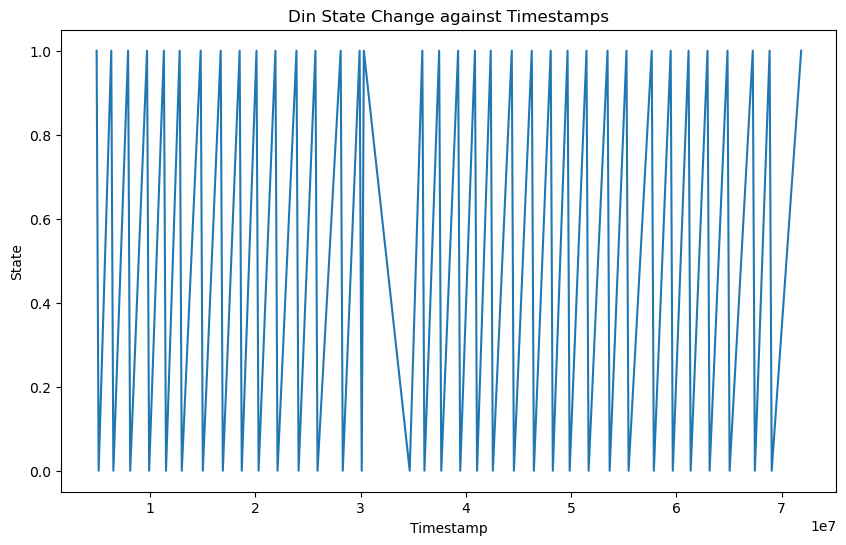

In [359]:
plt.plot([tup[0] for tup in tone_onset_DIN_state_array], [tup[1] for tup in tone_onset_DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

### Box 1 Port Entries

In [360]:
box1_port_entries_DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din3.dat", return_first=True)

In [361]:
box1_port_entries_DIN_file_name

'dio_ECU_Din3.dat'

In [362]:
box1_port_entries_DIN_state_array = DIO_directory_dict[box1_port_entries_DIN_file_name]["data"]

In [363]:
box1_port_entries_DIN_state_array

array([( 4919837, 1), ( 5110265, 0), ( 5120665, 1), ..., (71834201, 1),
       (71836198, 0), (71868601, 1)],
      dtype=[('time', '<u4'), ('state', 'u1')])

(array([2085.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2086.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

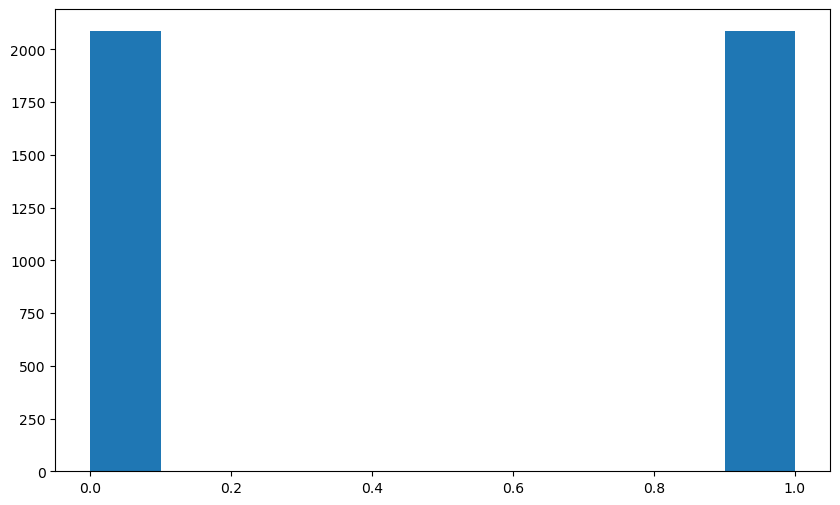

In [364]:
plt.hist([tup[1] for tup in box1_port_entries_DIN_state_array])

- There is a gap in the middle when the protocol was being changed between competition or omission

Text(0.5, 1.0, 'Din State Change against Timestamps')

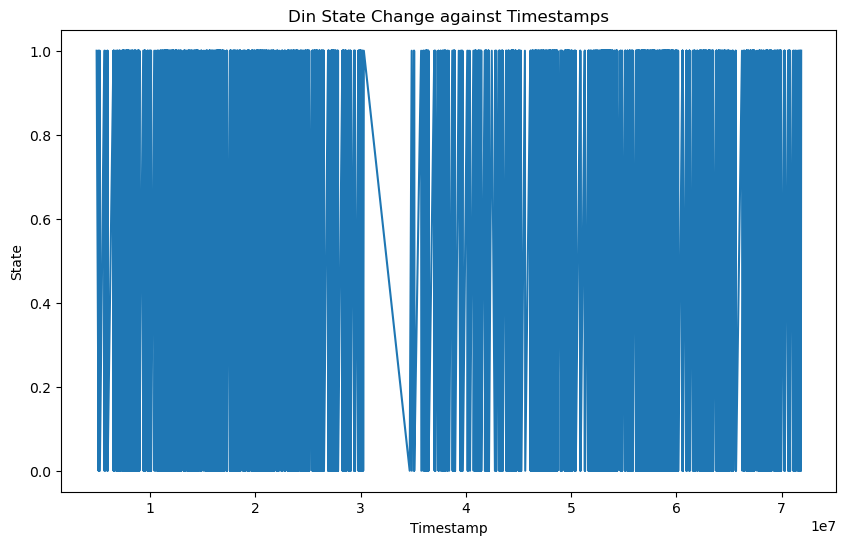

In [365]:
plt.plot([tup[0] for tup in box1_port_entries_DIN_state_array], [tup[1] for tup in box1_port_entries_DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

### Box 2 Port Entries

In [366]:
box2_port_entries_DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="dio_Controller_Din1.dat", return_first=True)

In [367]:
box2_port_entries_DIN_file_name

'dio_Controller_Din1.dat'

In [368]:
box2_port_entries_DIN_file_name = DIO_directory_dict[box2_port_entries_DIN_file_name]["data"]

In [369]:
box2_port_entries_DIN_file_name

array([( 4919837, 1), ( 5110263, 0), ( 5110662, 1), ( 5114262, 0),
       ( 5208062, 1), ( 5212862, 0), ( 5215262, 1), ( 5216262, 0),
       ( 5219062, 1), ( 5221860, 0), ( 5243662, 1), ( 5245260, 0),
       ( 5247262, 1), ( 5254065, 0), ( 5254462, 1), ( 5280060, 0),
       ( 5283462, 1), ( 5284462, 0), ( 5284862, 1), ( 5316862, 0),
       ( 6207292, 1), ( 6207304, 0), ( 6207305, 1), ( 6207308, 0),
       ( 6207336, 1), ( 6207387, 0), ( 6207400, 1), ( 6207434, 0),
       ( 6207435, 1), ( 6207436, 0), ( 6207443, 1), ( 6207494, 0),
       ( 6207496, 1), ( 6207501, 0), ( 6207562, 1), ( 6207564, 0),
       ( 6207566, 1), ( 6207568, 0), ( 6207569, 1), ( 6207572, 0),
       ( 6207573, 1), ( 6207594, 0), ( 6885461, 1), ( 6921058, 0),
       ( 6923061, 1), ( 6924058, 0), ( 6929061, 1), ( 6932061, 0),
       ( 6932463, 1), ( 6951858, 0), ( 7124858, 1), ( 7152260, 0),
       ( 7565260, 1), ( 7636060, 0), ( 7722060, 1), ( 7723867, 0),
       ( 7724460, 1), ( 7771660, 0), ( 8142857, 1), ( 8144059,

(array([167.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 168.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

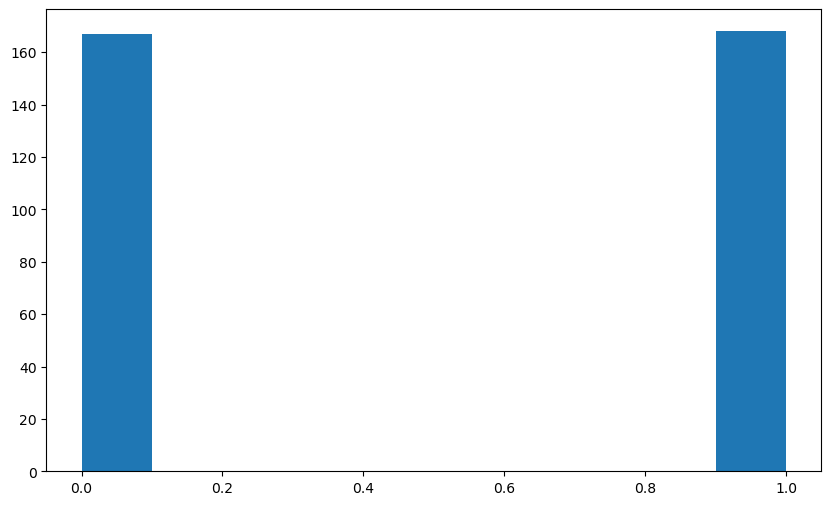

In [370]:
plt.hist([tup[1] for tup in box2_port_entries_DIN_file_name])

- This is half the time than the previous port entries, because the mouse was moved to box 1 for half of the session

Text(0.5, 1.0, 'Din State Change against Timestamps')

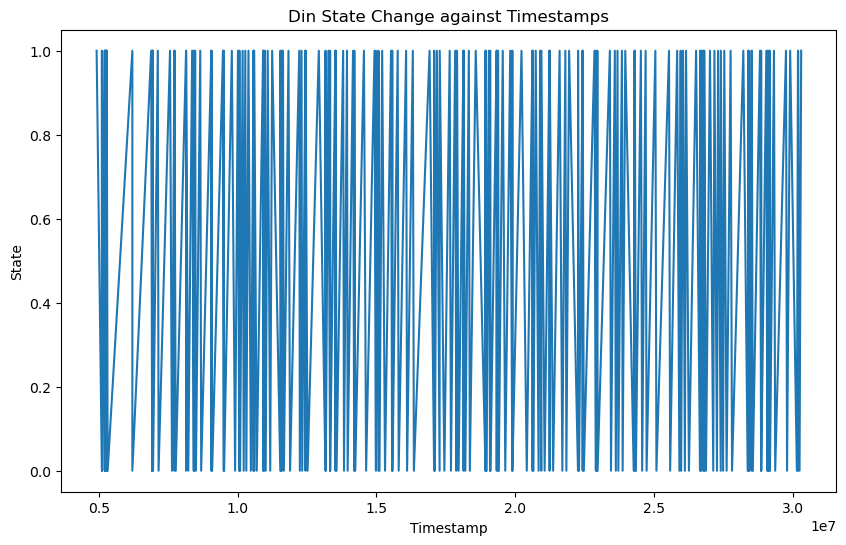

In [371]:
plt.plot([tup[0] for tup in box2_port_entries_DIN_file_name], [tup[1] for tup in box2_port_entries_DIN_file_name])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

## Labeling the Tone and Port Entries

# Syncing with MED-PC

- List of when the ECU has changed signal. 1 means that the ECU Din1 signal is on, 0 means it's off.

In [372]:
tone_onset_DIN_state_array

array([( 4919837, 1), ( 5110265, 0), ( 6310663, 1), ( 6510663, 0),
       ( 7910662, 1), ( 8110661, 0), ( 9710660, 1), ( 9910657, 0),
       (11310658, 1), (11510659, 0), (12810657, 1), (13010657, 0),
       (14810655, 1), (15010655, 0), (16710653, 1), (16910653, 0),
       (18510652, 1), (18710651, 0), (20110658, 1), (20310650, 0),
       (21910649, 1), (22110648, 0), (23910646, 1), (24110646, 0),
       (25710642, 1), (25910642, 0), (28110642, 1), (28310642, 0),
       (29910641, 1), (30110640, 0), (30310238, 1), (34668633, 0),
       (35869034, 1), (36069035, 0), (37469033, 1), (37669030, 0),
       (39269032, 1), (39469031, 0), (40869030, 1), (41069030, 0),
       (42369029, 1), (42569028, 0), (44369024, 1), (44569026, 0),
       (46269025, 1), (46469022, 0), (48069023, 1), (48269023, 0),
       (49669022, 1), (49869019, 0), (51469020, 1), (51669022, 0),
       (53469018, 1), (53669018, 0), (55269017, 1), (55469014, 0),
       (57669012, 1), (57869014, 0), (59469010, 1), (59669013,

- Checking to see if 1 or 0 is when the tone plays
    - Dividing by 20000, because we are recording at a sampling rate at 20000

In [373]:
tone_onset_DIN_state_array[0][0]

4919837

In [374]:
tone_onset_DIN_state_array[0][1]

1

In [375]:
tone_onset_DIN_state_array[1][0]

5110265

In [376]:
tone_onset_DIN_state_array[1][1]

0

In [377]:
tone_onset_DIN_state_array[2][0]

6310663

In [378]:
tone_onset_DIN_state_array[2][1]

1

- So the tone starts when the state is "1"
    - This can be seen because the time from 1 to 0 is less than 60 seconds

In [379]:
first_delay = (tone_onset_DIN_state_array[1][0] - tone_onset_DIN_state_array[0][0]) / 20000

In [380]:
first_delay

9.5214

- Time difference for on >>> off

In [381]:
(tone_onset_DIN_state_array[3][0] - tone_onset_DIN_state_array[2][0]) / 20000

10.0

- So the tone starts when the state is "2"
    - This can be seen because the time from 0 to 1 is 60 seconds, the time for one session

In [382]:
(tone_onset_DIN_state_array[2][0] - tone_onset_DIN_state_array[1][0]) / 20000

60.0199

- Getting only the times when the ECU signal was on

In [383]:
tone_din_time = [din_time for din_time, din_state in tone_onset_DIN_state_array if din_state == 1]

In [384]:
len(tone_din_time)

36

In [385]:
tone_din_time[:10]

[4919837,
 6310663,
 7910662,
 9710660,
 11310658,
 12810657,
 14810655,
 16710653,
 18510652,
 20110658]

# From DIN to Video

- State 1 is when the MED-PC signal is being recieved. And 0 is when it is turned off. So we will get the timestamp of when it is first 1.

In [386]:
tone_onset_DIN_state_array

array([( 4919837, 1), ( 5110265, 0), ( 6310663, 1), ( 6510663, 0),
       ( 7910662, 1), ( 8110661, 0), ( 9710660, 1), ( 9910657, 0),
       (11310658, 1), (11510659, 0), (12810657, 1), (13010657, 0),
       (14810655, 1), (15010655, 0), (16710653, 1), (16910653, 0),
       (18510652, 1), (18710651, 0), (20110658, 1), (20310650, 0),
       (21910649, 1), (22110648, 0), (23910646, 1), (24110646, 0),
       (25710642, 1), (25910642, 0), (28110642, 1), (28310642, 0),
       (29910641, 1), (30110640, 0), (30310238, 1), (34668633, 0),
       (35869034, 1), (36069035, 0), (37469033, 1), (37669030, 0),
       (39269032, 1), (39469031, 0), (40869030, 1), (41069030, 0),
       (42369029, 1), (42569028, 0), (44369024, 1), (44569026, 0),
       (46269025, 1), (46469022, 0), (48069023, 1), (48269023, 0),
       (49669022, 1), (49869019, 0), (51469020, 1), (51669022, 0),
       (53469018, 1), (53669018, 0), (55269017, 1), (55469014, 0),
       (57669012, 1), (57869014, 0), (59469010, 1), (59669013,

In [469]:
(6510663-6310663)/20000

10.0

In [387]:
tone_time_stamp = [time_state[0] for time_state in tone_onset_DIN_state_array if time_state[1]]

In [388]:
example_tone_time_stamp = tone_time_stamp[3]

In [389]:
example_tone_time_stamp

9710660

## Adding the DIN info

In [444]:
DIN_dataframe = pd.DataFrame(tone_onset_DIN_state_array)

In [445]:
DIN_dataframe["timestamp"] = DIN_dataframe["time"] - voltage_timestamp_array[0]

In [446]:
DIN_dataframe = DIN_dataframe[DIN_dataframe["state"] == 1].reset_index(drop=True)

In [447]:
timestamp_to_frame = video_df.set_index('timestamp')['index'].to_dict()

In [448]:
timestamp_to_frame

{0: 0,
 1385: 2,
 2771: 4,
 4157: 5,
 4232: 6,
 5543: 7,
 6929: 9,
 8315: 11,
 9701: 12,
 11086: 14,
 12472: 16,
 13858: 18,
 15244: 19,
 16630: 21,
 18016: 23,
 19402: 24,
 20788: 26,
 22173: 28,
 23559: 29,
 24945: 31,
 26331: 33,
 27717: 35,
 29103: 36,
 29826: 37,
 30489: 38,
 31874: 40,
 33260: 41,
 33303: 42,
 34646: 43,
 36032: 45,
 37418: 47,
 38804: 49,
 40190: 50,
 41576: 52,
 42961: 54,
 44347: 55,
 45733: 57,
 47119: 59,
 48505: 61,
 49891: 62,
 49898: 63,
 51277: 64,
 52663: 66,
 54048: 67,
 54675: 68,
 55434: 69,
 56820: 71,
 58206: 73,
 59592: 75,
 60978: 76,
 62364: 78,
 63749: 80,
 65135: 81,
 66521: 83,
 67907: 85,
 69293: 87,
 70679: 88,
 71797: 89,
 72065: 90,
 73451: 92,
 74836: 93,
 75604: 94,
 76222: 95,
 77608: 97,
 78994: 98,
 80380: 100,
 81766: 102,
 83152: 104,
 84538: 106,
 85923: 107,
 87309: 109,
 88695: 111,
 90081: 112,
 91467: 114,
 92853: 116,
 94239: 118,
 95624: 119,
 96588: 120,
 97010: 121,
 98396: 123,
 99782: 124,
 101073: 125,
 101168: 126,
 10

In [449]:
import bisect

def find_closest(my_list, my_number):
    """
    Assumes my_list is sorted. Returns the closest value to my_number.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect.bisect_left(my_list, my_number)
    if pos == 0:
        return my_list[0]
    else:
        return my_list[pos - 1]

In [450]:
sorted_frame_timestamps = sorted(timestamp_to_frame.keys())

In [451]:
sorted_frame_timestamps[:10]

[0, 1385, 2771, 4157, 4232, 5543, 6929, 8315, 9701, 11086]

In [452]:
DIN_dataframe["video_frame"] = DIN_dataframe["timestamp"].apply(lambda x: timestamp_to_frame[find_closest(sorted_frame_timestamps, x)])


In [460]:
DIN_dataframe = DIN_dataframe.drop(DIN_dataframe.index[[0, -1]])

In [462]:
DIN_dataframe = DIN_dataframe.drop([15])

In [465]:
DIN_dataframe["tone_label"] = ['rewarded',
'rewarded',
'rewarded',
'omission',
'rewarded',
'rewarded',
'rewarded',
'rewarded',
'omission',
'rewarded',
'rewarded',
'omission',
'rewarded',
'rewarded',
'win',
'win',
'win',
'win',
'win',
'win',
'win',
'win',
'win',
'win',
'win',
'win',
'win',
'win',
'win',
'win',
'win',
'win',
'win']

In [467]:
DIN_dataframe

,time,state,timestamp,video_frame,tone_label
1,6310663,1,1390826,1733,rewarded
2,7910662,1,2990825,3728,rewarded
3,9710660,1,4790823,5971,rewarded
4,11310658,1,6390821,7966,omission
5,12810657,1,7890820,9835,rewarded
6,14810655,1,9890818,12328,rewarded
7,16710653,1,11790816,14696,rewarded
8,18510652,1,13590815,16940,rewarded
9,20110658,1,15190821,18936,omission
10,21910649,1,16990812,21180,rewarded


In [468]:
DIN_dataframe.to_csv("./proc/reward_tone_outcome_20221202_subj_6_1_vs_6_2.csv")